In [ ]:
import os
import os.path
import zipfile
import requests
import json
import pandas as pd
import sqlite3

Get Crime Incidents February 2017 to 5th July 2023 for PG county

In [ ]:
def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

url = 'https://github.com/dreyes53/data602-crime/raw/master/backend/historical_crime_data.db'
local_path = './historical_crime_data.db'

# Grab the file from our Github repo and download it if it doesn's exist
# and extract files
if not os.path.isfile(local_path):
  print('downloading historical_crime_data.db file...')
  download_url(url, local_path)
  print('historical_crime_data.db file downloaded.')
else:
  print('historical_crime_data.db file exists.')

conn = sqlite3.connect(local_path)
historical_df = pd.read_sql('SELECT * FROM crimes', conn)

historical_df.head()

downloading historical_crime_data.db file...
historical_crime_data.db file downloaded.


,index,incident_case_id,date,clearance_code_inc_type,pgpd_reporting_area,pgpd_sector,pgpd_beat,street_address,latitude,longitude,street_number
0,0,PP17020200002452,2017-02-02T00:00:00.000,ACCIDENT,826,D,D1,96TH AVE / GOOD LUCK RD,38.98081897199154,-76.84693802893162,None
1,1,PP17020300000263,2017-02-03T00:00:00.000,ACCIDENT,602,J,J4,INDIAN HEAD HWY SB / WILSON BRIDGE DR,38.78724980354309,-76.99851253628731,None
2,2,PP17020300001861,2017-02-03T00:00:00.000,THEFT,405,H,H2,1484 ADDISON RD S,38.86697405576706,-76.89221352338791,1400 BLOCK
3,3,PP17020300000798,2017-02-03T00:00:00.000,THEFT FROM AUTO,219,B,B63,4500 COLLEGE AVE,38.98213131725788,-76.93781711161137,4500 BLOCK
4,4,PP17020300001916,2017-02-03T00:00:00.000,ACCIDENT,423,H,H7,5510 SILVER HILL RD SB,38.85286647081375,-76.91321086883545,5500 BLOCK


Get Crime Incidents July 2023 to Present and merge with Historical crime data

In [ ]:
offset = 0
limit = 10000
full_present_crime_data = []

while True:
  url = f'https://data.princegeorgescountymd.gov/resource/xjru-idbe.json?$offset={offset}&$limit={limit}'
  x = requests.get(url)
  nested = json.loads(json.dumps(x.json(), indent=2))
  if len(nested) == 0:
    break
  full_present_crime_data = full_present_crime_data + nested
  offset = offset + limit

print("Number of Crime Incidents July 2023 to Present:", len(full_present_crime_data))
present_df = pd.json_normalize(full_present_crime_data)
present_df = present_df[present_df['location'].notna()]
present_df = present_df.drop(columns=['location'])

frames = [historical_df, present_df]
historical_df = pd.concat(frames, ignore_index=True)


historical_df['date']= pd.to_datetime(historical_df['date'])
historical_df['day_of_week'] = historical_df['date'].dt.dayofweek
historical_df['day_of_week'] = historical_df['day_of_week'].map({
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
})
historical_df['latitude'] = pd.to_numeric(historical_df['latitude'])
historical_df['longitude'] = pd.to_numeric(historical_df['longitude'])

historical_df = historical_df[(historical_df['latitude'] > 30) & (historical_df['latitude'] < 40)]
historical_df = historical_df[(historical_df['longitude'] > -80) & (historical_df['longitude'] < -75)]
#lowend 30-latitude -80-longitude
#highend 40-latidutue -75-logitude

print("Number of Crime Incidents February 2017 to Present:", len(historical_df.index))
historical_df.head()

Number of Crime Incidents July 2023 to Present: 12484
Number of Crime Incidents February 2017 to Present: 163044


,index,incident_case_id,date,clearance_code_inc_type,pgpd_reporting_area,pgpd_sector,pgpd_beat,street_address,latitude,longitude,street_number,day_of_week
0,0.0,PP17020200002452,2017-02-02,ACCIDENT,826,D,D1,96TH AVE / GOOD LUCK RD,38.980819,-76.846938,None,Thursday
1,1.0,PP17020300000263,2017-02-03,ACCIDENT,602,J,J4,INDIAN HEAD HWY SB / WILSON BRIDGE DR,38.787250,-76.998513,None,Friday
2,2.0,PP17020300001861,2017-02-03,THEFT,405,H,H2,1484 ADDISON RD S,38.866974,-76.892214,1400 BLOCK,Friday
3,3.0,PP17020300000798,2017-02-03,THEFT FROM AUTO,219,B,B63,4500 COLLEGE AVE,38.982131,-76.937817,4500 BLOCK,Friday
4,4.0,PP17020300001916,2017-02-03,ACCIDENT,423,H,H7,5510 SILVER HILL RD SB,38.852866,-76.913211,5500 BLOCK,Friday


Creating a new column displaying just the month and year (for grouping purposes).

In [ ]:
historical_df['month_year'] = historical_df['date'].dt.to_period('M')

historical_df.head()

,index,incident_case_id,date,clearance_code_inc_type,pgpd_reporting_area,pgpd_sector,pgpd_beat,street_address,latitude,longitude,street_number,day_of_week,month_year
0,0.0,PP17020200002452,2017-02-02,ACCIDENT,826,D,D1,96TH AVE / GOOD LUCK RD,38.980819,-76.846938,None,Thursday,2017-02
1,1.0,PP17020300000263,2017-02-03,ACCIDENT,602,J,J4,INDIAN HEAD HWY SB / WILSON BRIDGE DR,38.787250,-76.998513,None,Friday,2017-02
2,2.0,PP17020300001861,2017-02-03,THEFT,405,H,H2,1484 ADDISON RD S,38.866974,-76.892214,1400 BLOCK,Friday,2017-02
3,3.0,PP17020300000798,2017-02-03,THEFT FROM AUTO,219,B,B63,4500 COLLEGE AVE,38.982131,-76.937817,4500 BLOCK,Friday,2017-02
4,4.0,PP17020300001916,2017-02-03,ACCIDENT,423,H,H7,5510 SILVER HILL RD SB,38.852866,-76.913211,5500 BLOCK,Friday,2017-02


Function to sort crimes into one-month bins.

In [ ]:
def month_bin_df(df):
  month_list_total = df['month_year'].tolist()
  month_list = set(month_list_total)
  month_list = list(month_list)

  occ_list = np.zeros(len(month_list))
  for i in range(len(month_list)):
    for month in month_list_total:
      if month == month_list[i]:
        occ_list[i] += 1

  new_df = pd.DataFrame()
  new_df['month'] = month_list
  new_df['occurrences'] = occ_list

  new_df = new_df.sort_values(by='month')
  new_df = new_df.reset_index(drop=True)
  return(new_df)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import matplotlib.dates as mdates

Functions that apply polynomial regression to the data, finding the optimal fit.

In [ ]:
def generate_regression(df, deg):
  x = df.index.values.tolist()
  y = df['occurrences'].values.tolist()
  train_x = []
  test_x = []
  train_y = []
  test_y = []
  for i in range(len(x)):
    if (i % 4 == 0):
      test_x.append(x[i])
      test_y.append(y[i])
    else:
      train_x.append(x[i])
      train_y.append(y[i])

  coeff = np.polyfit(train_x, train_y, deg)

  y_pred = np.polyval(coeff, test_x)
  MSE = np.mean((y_pred - test_y) ** 2)

  return coeff, MSE


def optimal_fit(df, deg_to_try, title):
  test_index = df.index[-1]
  test_actual = df.at[test_index, 'occurrences']

  df = df.drop(test_index)
  min_MSE = 1e7
  optimal_degree = 0
  optimal_coeff = []
  for deg in deg_to_try:
    c, m = generate_regression(df, deg)
    if m < min_MSE:
      min_MSE = m
      optimal_degree = deg
      optimal_coeff = c

  x = df.index.values.tolist()
  y = df['occurrences'].values.tolist()

  x_line = np.arange(min(x), max(x), 0.01)
  y_line = np.polyval(optimal_coeff, x_line)

  plt.scatter(x, y)
  plt.plot(x_line, y_line, color='red')
  reference_date = datetime(2017, 2, 1)
  dates = [reference_date + timedelta(days=i*30) for i in x]
  tick_labels = [(reference_date + timedelta(days=i*30)).strftime('%b %Y') for i in x]
  plt.xticks(x[::12], tick_labels[::12])
  plt.xlabel('Month(Feb 2017 = 0)')
  plt.ylabel('Occurrences')
  plt.title(title + ", " + str(optimal_degree) + "th Degree Best Fit")

  prediction = np.polyval(optimal_coeff, test_index)
  pct_error = 100*(prediction - test_actual)/test_actual
  print("Error for test: ", pct_error)

  return optimal_coeff

Sorting the monthly data into bins

Error for test:  17.24855090665742


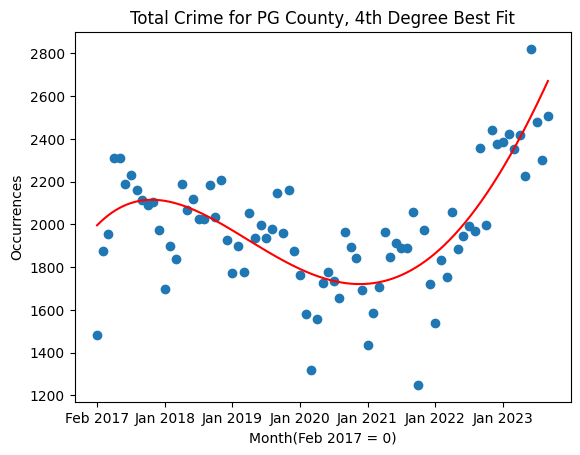

In [ ]:
total_bins = month_bin_df(historical_df).drop(82)  # Dropping December data as the month is incomplete

deg = [i for i in range(6)]
best_fit_total = optimal_fit(total_bins, deg, 'Total Crime for PG County')

Text(0, 0.5, 'Occurrences')

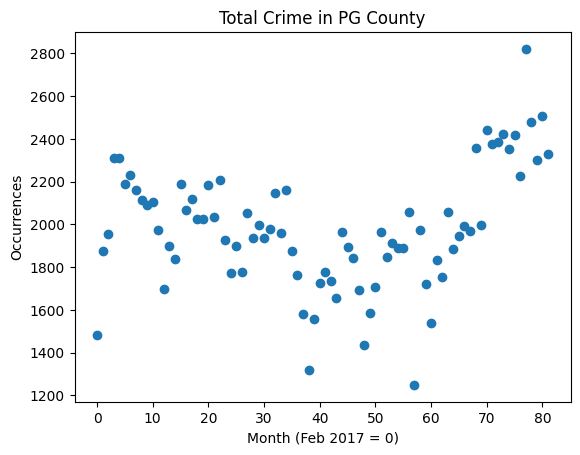

In [ ]:
plt.scatter(total_bins.index.values.tolist(), total_bins['occurrences'].values.tolist())
plt.title("Total Crime in PG County")
plt.xlabel("Month (Feb 2017 = 0)")
plt.ylabel("Occurrences")

Prediction for month of December

In [ ]:
next_month = len(total_bins)

new_prediction = np.polyval(best_fit_total, next_month)

print("This model predicts ", round(new_prediction, 0), " total crime occurrences for the upcoming month.")

This model predicts  2789.0  total crime occurrences for the upcoming month.


Printing a list of incident types to use as a reference

In [ ]:
incident_types = historical_df['clearance_code_inc_type'].tolist()

incident_types = set(incident_types)

incident_types = list(incident_types)

incident_types

['HOMICIDE',
 'ROBBERY, RESIDENTIAL',
 'B & E, OTHER',
 'AUTO, STOLEN',
 'B & E, COMMERCIAL',
 'ROBBERY, COMMERCIAL',
 'ACCIDENT',
 'SEX OFFENSE',
 'ROBBERY, VEHICLE',
 'B & E, VACANT',
 'ASSAULT',
 'ASSAULT, WEAPON',
 'VANDALISM',
 'B & E, RESIDENTIAL (VACANT)',
 'ROBBERY, OTHER',
 'THEFT',
 'B & E, SCHOOL',
 'THEFT FROM AUTO',
 'B & E, RESIDENTIAL',
 'ASSAULT, SHOOTING',
 'ACCIDENT WITH IMPOUND',
 'AUTO, STOLEN & RECOVERED']

Functions to allow for the same polynomial regression calculation to be performed with a specific type of crime data

In [ ]:
def find_missing_months(months):
    # Create a set of all months in the range
    full_range_set = set(pd.period_range(start=min(months), end=max(months), freq='M'))

    # Create a set of months from the given list
    given_months_set = set(months)

    # Find the difference to get the missing months
    missing_months = sorted(list(full_range_set - given_months_set))

    return missing_months


def spec_type(df, types, title, return_spec_bins=False):
  spec_df = historical_df[historical_df['clearance_code_inc_type'].isin(types)]
  spec_df = spec_df.reset_index(drop=True)
  spec_bins = month_bin_df(spec_df).drop(82)

  missing = find_missing_months(spec_bins['month'].tolist())

  not_missing = len(spec_bins)

  for i in range(len(missing)):
    spec_bins.at[not_missing + i, 'month'] = missing[i]
    spec_bins.at[not_missing + i, 'occurrences'] = 0

  spec_bins = spec_bins.sort_values(by='month')
  spec_bins = spec_bins.reset_index(drop=True)
  if return_spec_bins:
    return spec_bins

  deg = [i for i in range(6)]
  best_fit_spec = optimal_fit(spec_bins, deg, title)

  spec_prediction = np.polyval(best_fit_spec, next_month)

  print("This model predicts ", round(spec_prediction, 0), " crime occurrences under specified parameters for the upcoming month.")

Projecting Violent Crime

Error for test:  4.19994176547533
This model predicts  124.0  crime occurrences under specified parameters for the upcoming month.


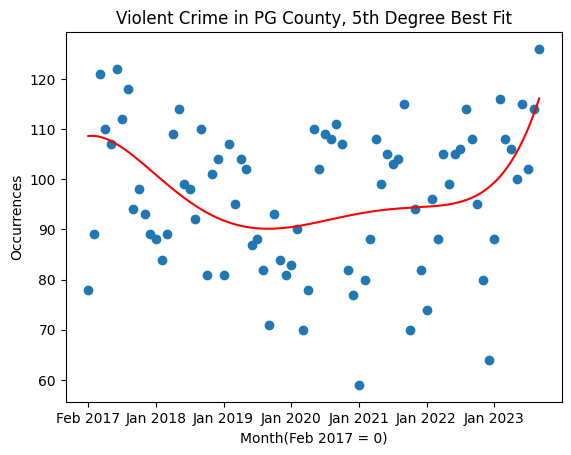

In [ ]:
types_list = ['ASSAULT, WEAPON', 'ASSAULT', 'ASSAULT, SHOOTING', 'HOMICIDE']

spec_type(historical_df, types_list, 'Violent Crime in PG County')

Projecting Accidents

Error for test:  4.058555713606002
This model predicts  833.0  crime occurrences under specified parameters for the upcoming month.


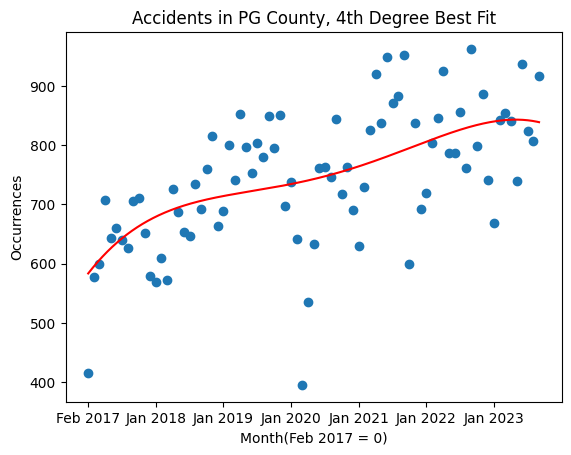

In [ ]:
types_list = ['ACCIDENT', 'ACCIDENT WITH IMPOUND']

accident_df = spec_type(historical_df, types_list, 'Accidents in PG County')

In [ ]:
!pip install prophet

In [ ]:
from prophet import Prophet

Generating a plain Prophet predictive model

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph61vri_8/zf402zyt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph61vri_8/oj0vfpk8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1775', 'data', 'file=/tmp/tmph61vri_8/zf402zyt.json', 'init=/tmp/tmph61vri_8/oj0vfpk8.json', 'output', 'file=/tmp/tmph61vri_8/prophet_model1nbtzjie/prophet_model-20231213011619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:16:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:16:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Forecast: 
             ds      yhat
2498 2023-12-09  4.505765
2499 2023-12-10  4.451249
2500 2023-12-11  4.607158
2501 2023-12-12  4.600689
2502 2023-12-13  4.583576
2503 2023-12-14  4.587872
2504 2023-12-15  4.645466


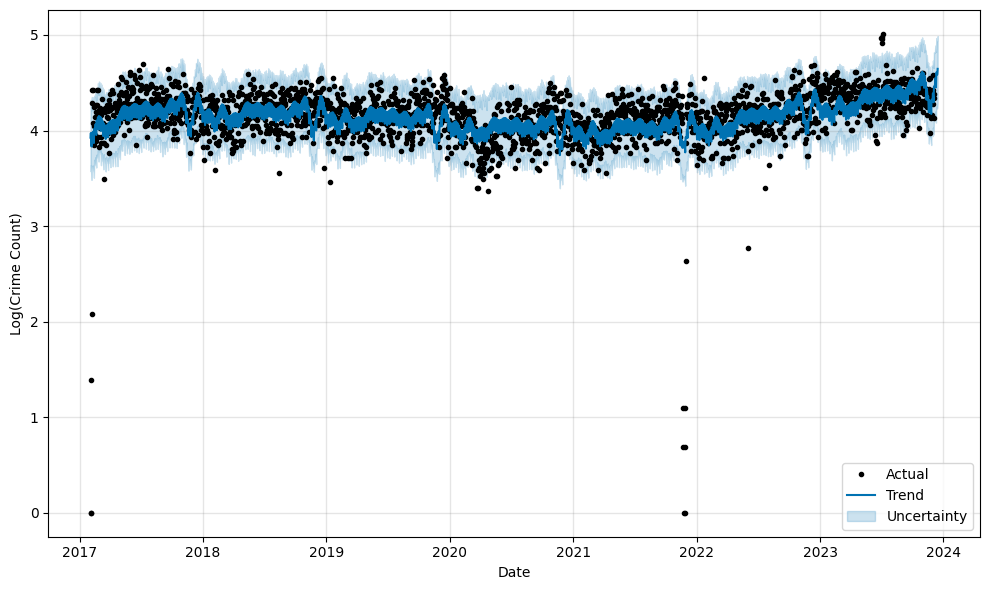

In [ ]:
historical_df['date'] = pd.to_datetime(historical_df['date']).dt.date
df = historical_df.groupby('date').count()['clearance_code_inc_type'].to_frame()
df.reset_index(inplace=True)
df.columns = ['ds','y']
df.head()

# Starting by making a copy of the data frame
df_m1 = df.copy()

# The only transformation we'll do is a 'log transformation' of y
df_m1['y'] = np.log(df_m1['y'])

# Prophet code are basically these lines
m1_plain = Prophet()
m1_plain.fit(df_m1)

# Let's try a forecast for 7 days
future = m1_plain.make_future_dataframe(periods=10)
forecast_m1 = m1_plain.predict(future)

m1_plain.plot(forecast_m1)
plt.xlabel('Date')
plt.ylabel('Log(Crime Count)')
plt.legend(['Actual', 'Trend', 'Uncertainty'])
# Number of crimes forecast for the next 7 daysß
print("Forecast: ")
print(forecast_m1[forecast_m1['ds'] > pd.Timestamp(2023, 12, 8)][['ds', 'yhat']])

Displaying the Components

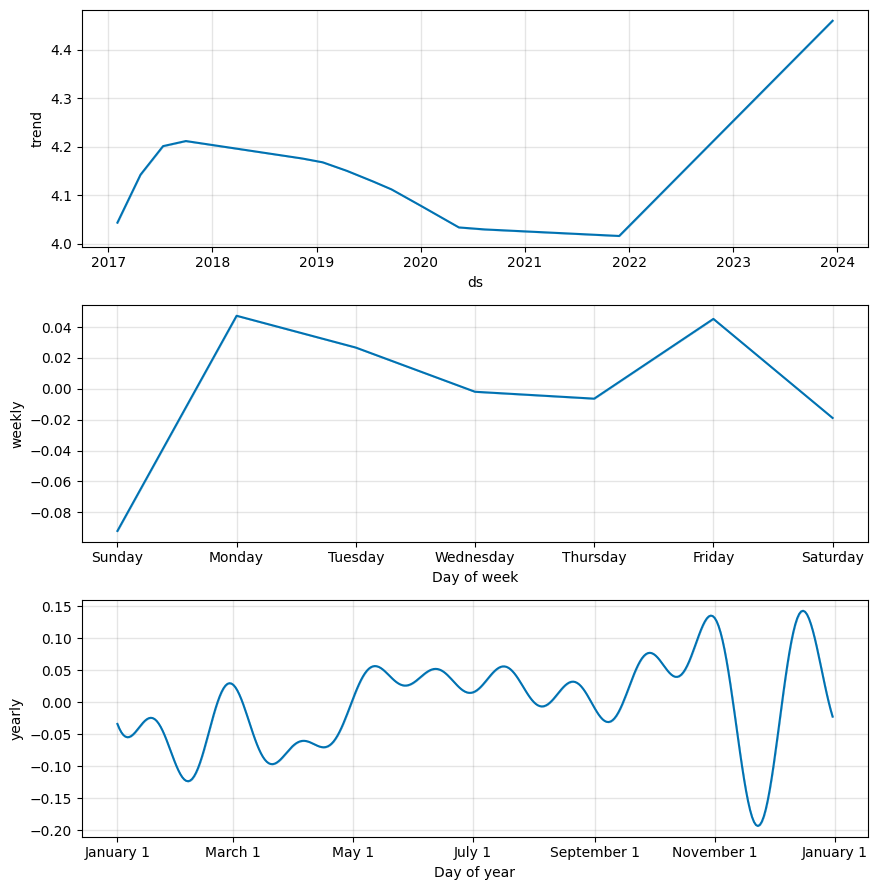

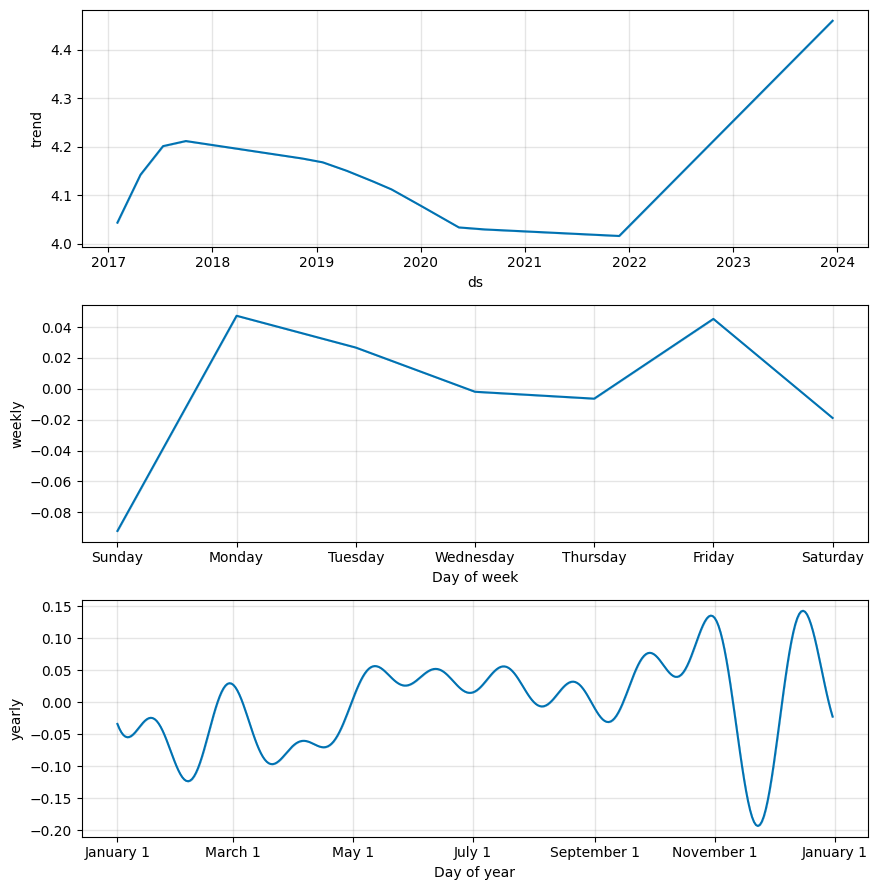

In [ ]:
m1_plain.plot_components(forecast_m1)

Finding MAPE

In [ ]:
# First, let's get some useful variables: "y" for the actual value and "n" for the number of observations.
y = df['y'].to_frame()
y.index = df['ds']
n = np.int(y.count())

# The forecast is 'log transformed', so we need to 'inverse' it back by using the exp
forecast_m1_exp = np.exp(forecast_m1[['yhat','yhat_lower','yhat_upper']])
forecast_m1_exp.index = forecast_m1['ds']

# Now let's calculate the Mean Absolute Percentage Error (MAPE) for m1
error = forecast_m1_exp['yhat'] - y['y']
MAPE_m1 = (error/y['y']).abs().sum()/n *100
round(MAPE_m1,2)

<ipython-input-19-8c1a93fc32c3>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n = np.int(y.count())


25.31

An updated model that removes outliers

<ipython-input-20-c74ac630a9f6>:5: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  ucl = df_m2.mean() + df_m2.std()*3
<ipython-input-20-c74ac630a9f6>:5: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  ucl = df_m2.mean() + df_m2.std()*3
<ipython-input-20-c74ac630a9f6>:6: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this war

Above 3 standard deviations:  6 entries
Below 3 standard deviations:  12 entries


01:16:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat
2464,2023-11-23,4.378091
2465,2023-11-24,4.437761
2466,2023-11-25,4.385300
2467,2023-11-26,4.307860
2468,2023-11-27,4.450199
2469,2023-11-28,4.423767
2470,2023-11-29,4.418335
2471,2023-11-30,4.421220
2472,2023-12-01,4.487897
2473,2023-12-02,4.441601


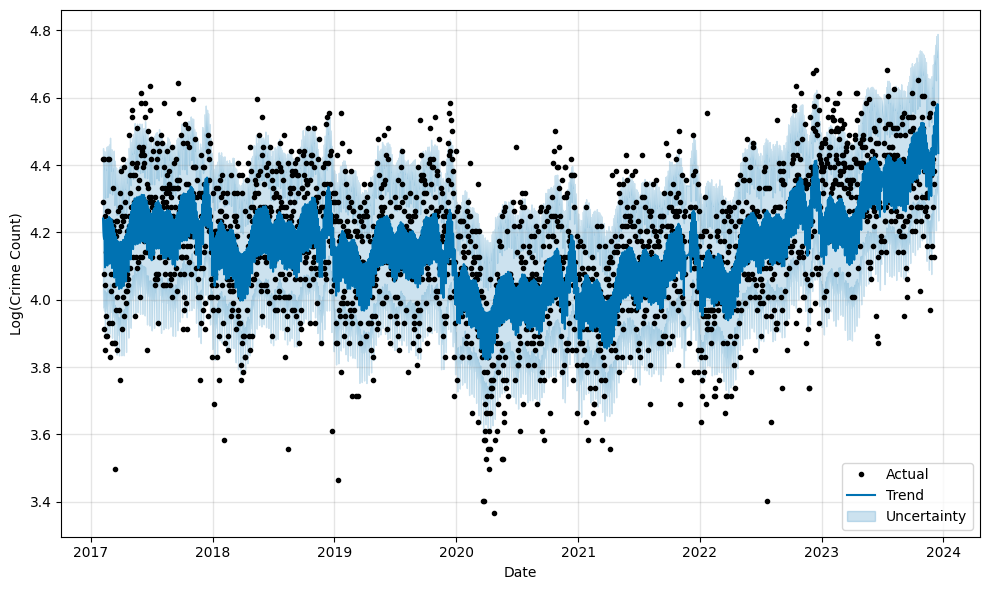

In [ ]:
# Make another copy of the data frame as m2
df_m2 = df.copy()

# Define the Upper Control Limit and Lower Control Limit as 3 standard deviations from the mean
ucl = df_m2.mean() + df_m2.std()*3
lcl = df_m2.mean() - df_m2.std()*3

# Print the number of outliers found
print('Above 3 standard deviations: ', df_m2[df_m2['y'] > ucl['y']]['y'].count(), 'entries')
print('Below 3 standard deviations: ', df_m2[df_m2['y'] < lcl['y']]['y'].count(), 'entries')

# Remove them by setting their value to None. Prophet says it can handle null values.
df_m2.loc[df_m2['y'] > ucl['y'], 'y'] = None
df_m2.loc[df_m2['y'] < lcl['y'], 'y'] = None

# Log transformation
df_m2['y'] = np.log(df_m2['y'])

# Run Prophet using model 2
m2_no_outlier = Prophet()
m2_no_outlier.fit(df_m2)
future = m2_no_outlier.make_future_dataframe(periods=12)
forecast_m2 = m2_no_outlier.predict(future)

m2_no_outlier.plot(forecast_m2)
plt.xlabel('Date')
plt.ylabel('Log(Crime Count)')
plt.legend(['Actual', 'Trend', 'Uncertainty'])
forecast_m2[forecast_m2['ds'] > pd.Timestamp(2023, 11, 22)][['ds', 'yhat']]

From this model, generating a prediction for the ensuing week

In [ ]:
next_week = forecast_m2[forecast_m2['ds'] > pd.Timestamp(2023, 12, 10)].copy()

for index, row in next_week.iterrows():
  next_week.at[index, 'prediction'] = np.exp(row['yhat'])
prediction = next_week['prediction'].sum()

print("Predicted number of crime incidents in the next week: ", round(prediction,0))

Predicted number of crime incidents in the next week:  650.0


In [ ]:
historical_df.tail()

,index,incident_case_id,date,clearance_code_inc_type,pgpd_reporting_area,pgpd_sector,pgpd_beat,street_address,latitude,longitude,street_number,day_of_week,month_year
163043,NaN,PP23071700001200,2023-07-17,THEFT FROM AUTO,940,C,C1,10925 BALTIMORE AVE NB,39.032328,-76.907962,10900 BLOCK,Monday,2023-07
163044,NaN,PP23070400000196,2023-07-04,THEFT,206,B,B63,7300 BALTIMORE AVE SB,38.979835,-76.938473,7300 BLOCK,Tuesday,2023-07
163045,NaN,PP23070100001094,2023-07-01,THEFT,504,K,K1,4208 21ST AVE,38.831541,-76.964064,4200 BLOCK,Saturday,2023-07
163046,NaN,PP23102900000385,2023-10-29,ACCIDENT,441,H,H2,5604 SILVER HILL RD SB,38.855819,-76.910914,5600 BLOCK,Sunday,2023-10
163047,NaN,PP23072300001629,2023-07-23,ACCIDENT WITH IMPOUND,328,G,G5,BRIGHTSEAT RD / ARDWICK ARDMORE RD,38.936200,-76.856781,NaN,Sunday,2023-07


**Examining model's prediction from prior week**
(Current data runs through December 5th)

In [ ]:
prior_week = forecast_m2[(forecast_m2['ds'] > pd.Timestamp(2023, 11, 28)) & (forecast_m2['ds'] < pd.Timestamp(2023, 12, 6))].copy()

for index, row in prior_week.iterrows():
  prior_week.at[index, 'prediction'] = np.exp(row['yhat'])
prediction = prior_week['prediction'].sum()

print("Predicted number of crime incidents in the prior week: ", round(prediction,0))
prior_week_total = historical_df[historical_df['date'] > pd.Timestamp(2023, 11, 28)].copy()
print("Actual number of crime incidents in prior week ", len(prior_week_total))

Predicted number of crime incidents in the prior week:  600.0


<ipython-input-23-1f8c63aa5e07>:8: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  prior_week_total = historical_df[historical_df['date'] > pd.Timestamp(2023, 11, 28)].copy()


Actual number of crime incidents in prior week  536


Plotting Components of This Model

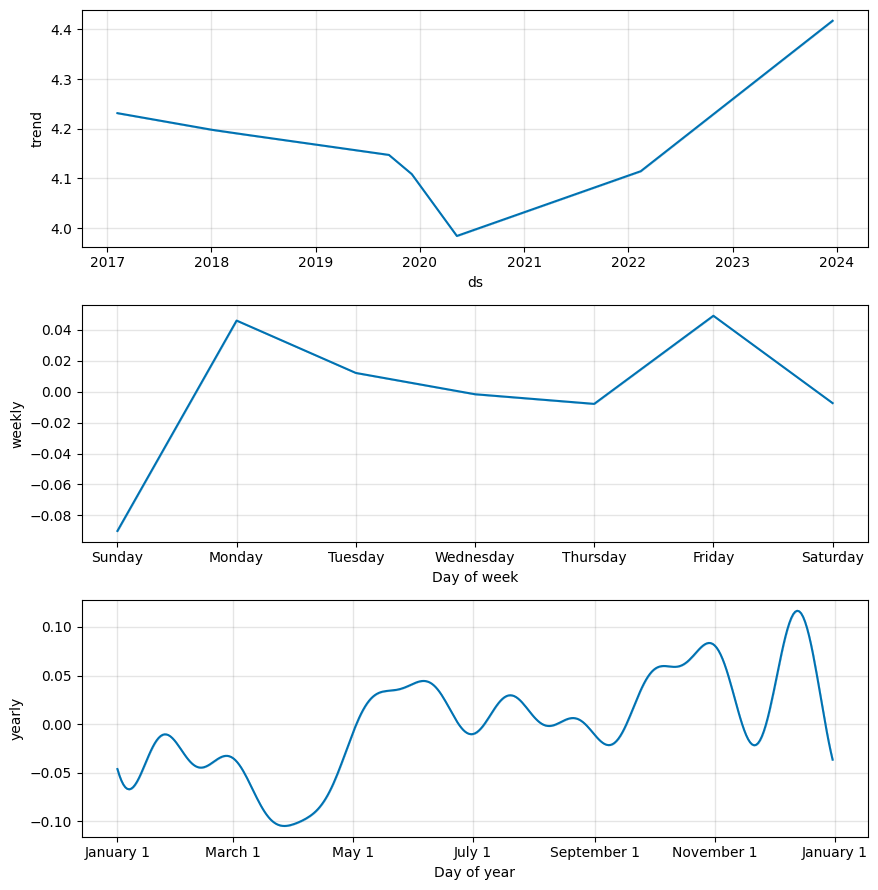

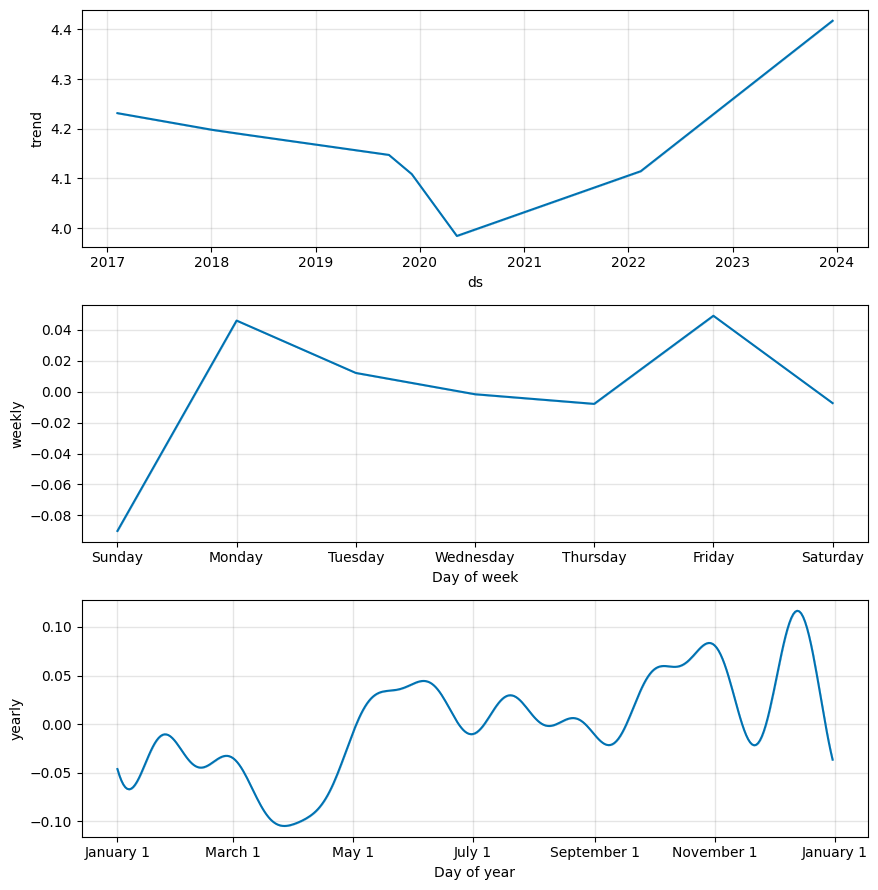

In [ ]:
m2_no_outlier.plot_components(forecast_m2)

Calculating MAPE for this new, no-outlier model

In [ ]:
# Inverse the log
forecast_m2_exp = np.exp(forecast_m2[['yhat','yhat_lower','yhat_upper']])
forecast_m2_exp.index = forecast_m2['ds']

# Calculate the error
error = forecast_m2_exp['yhat'] - y['y']
MAPE_m2 = (error/y['y']).abs().sum()/n *100
round(MAPE_m2,2)

13.25

A third model that incorporates holidays

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph61vri_8/hslnsiq_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph61vri_8/l5x95y_p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57899', 'data', 'file=/tmp/tmph61vri_8/hslnsiq_.json', 'init=/tmp/tmph61vri_8/l5x95y_p.json', 'output', 'file=/tmp/tmph61vri_8/prophet_model25c6d1ov/prophet_model-20231213011631.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:16:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:16:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat
2464,2023-11-23,4.380332
2465,2023-11-24,4.440383
2466,2023-11-25,4.390426
2467,2023-11-26,4.310747
2468,2023-11-27,4.453930
2469,2023-11-28,4.425133
2470,2023-11-29,4.419736
2471,2023-11-30,4.421640
2472,2023-12-01,4.488801
2473,2023-12-02,4.445169


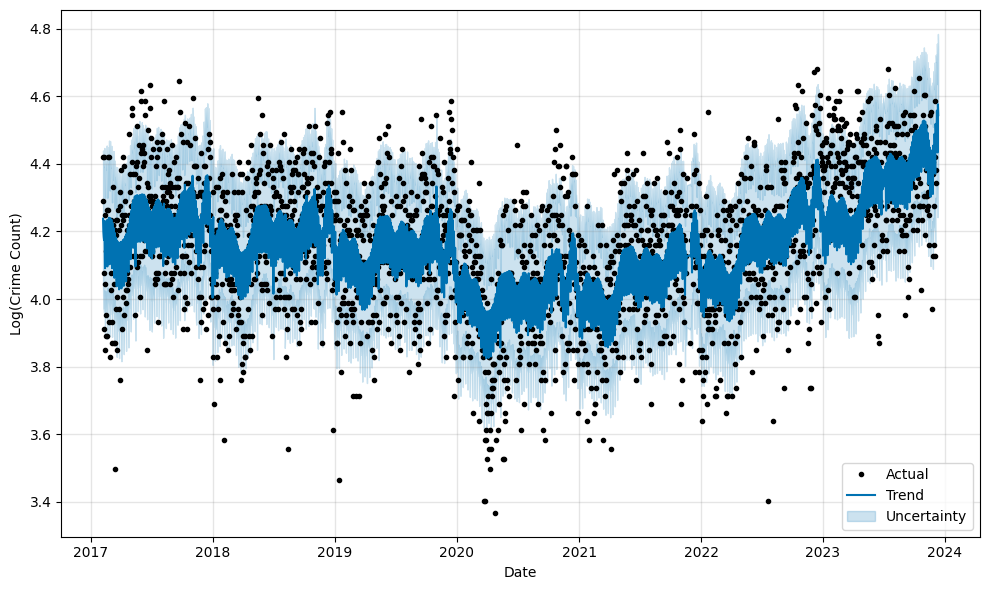

In [ ]:
# Using three sets of holidays.

# One with no added window: Mother's day, Victoria Day, Canada Day, Labour Day, Remembrance Day, Christmas.
# Another with a -1 lower and 1 upper window: Halloween, New Year's
# And another with a -2 lower and a 1 upper window: BC Day and Thanksgiving (long weekends)

holidays_0 = pd.DataFrame({
        'holiday': '0 window',
        'ds' :pd.to_datetime(
            ['2003-05-11','2004-05-09','2005-05-08','2006-05-14','2007-05-13','2008-05-11','2009-05-10','2010-05-09','2011-05-08','2012-05-13','2013-05-12','2014-05-11','2015-05-10','2016-05-08','2017-05-14','2018-05-13','2019-05-12','2020-05-10','2003-05-19','2004-05-24','2005-05-23','2006-05-22','2007-05-21','2008-05-19','2009-05-18','2010-05-24','2011-05-23','2012-05-21','2013-05-20','2014-05-19','2015-05-18','2016-05-23','2017-05-22','2018-05-21','2019-05-20','2020-05-18','2003-07-01','2004-07-01','2005-07-01','2006-07-01','2007-07-01','2008-07-01','2009-07-01','2010-07-01','2011-07-01','2012-07-01','2013-07-01','2014-07-01','2015-07-01','2016-07-01','2017-07-01','2018-07-01','2019-07-01','2020-07-01','2003-09-01','2004-09-06','2005-09-05','2006-09-04','2007-09-03','2008-09-01','2009-09-07','2010-09-06','2011-09-05','2012-09-03','2013-09-02','2014-09-01','2015-09-07','2016-09-05','2017-09-04','2018-09-03','2019-09-02','2020-09-07','2003-11-11','2004-11-11','2005-11-11','2006-11-11','2007-11-11','2008-11-11','2009-11-11','2010-11-11','2011-11-11','2012-11-11','2013-11-11','2014-11-11','2015-11-11','2016-11-11','2017-11-11','2018-11-11','2019-11-11','2020-11-11','2003-12-25','2004-12-25','2005-12-25','2006-12-25','2007-12-25','2008-12-25','2009-12-25','2010-12-25','2011-12-25','2012-12-25','2013-12-25','2014-12-25','2015-12-25','2016-12-25','2017-12-25','2018-12-25','2019-12-25','2020-12-25']),
        'lower_window' : 0,
        'upper_window' : 0,
    })

holidays_1 = pd.DataFrame({
        'holiday': '1 window',
        'ds' :pd.to_datetime(
            ['2003-10-31','2004-10-31','2005-10-31','2006-10-31','2007-10-31','2008-10-31','2009-10-31','2010-10-31','2011-10-31','2012-10-31','2013-10-31','2014-10-31','2015-10-31','2016-10-31','2017-10-31','2018-10-31','2019-10-31','2020-10-31','2003-01-01','2004-01-01','2005-01-01','2006-01-01','2007-01-01','2008-01-01','2009-01-01','2010-01-01','2011-01-01','2012-01-01','2013-01-01','2014-01-01','2015-01-01','2016-01-01','2017-01-01','2018-01-01','2019-01-01','2020-01-01']),
        'lower_window' : -1,
        'upper_window' : 1,
    })

holidays_2 = pd.DataFrame({
        'holiday': '2 window',
        'ds' :pd.to_datetime(
            ['2003-08-04','2004-08-02','2005-08-01','2006-08-07','2007-08-06','2008-08-04','2009-08-03','2010-08-02','2011-08-01','2012-08-06','2013-08-05','2014-08-04','2015-08-03','2016-08-01','2017-08-07','2018-08-06','2019-08-05','2020-08-03','2003-10-13','2004-10-11','2005-10-10','2006-10-09','2007-10-08','2008-10-13','2009-10-12','2010-10-11','2011-10-10','2012-10-08','2013-10-14','2014-10-13','2015-10-12','2016-10-10','2017-10-09','2018-10-08','2019-10-14','2020-10-12']),
        'lower_window' : -2,
        'upper_window' : 1,
    })

# Concatenate all 3 df into 1
holidays_list = pd.concat((holidays_0, holidays_1, holidays_2))

# Now we pass the holidays variable when we instantiate Prophet
m3_holidays = Prophet(holidays=holidays_list)
m3_holidays.fit(df_m2)
future = m3_holidays.make_future_dataframe(periods=7)
forecast_m3 = m3_holidays.predict(future)

m3_holidays.plot(forecast_m3)
plt.xlabel('Date')
plt.ylabel('Log(Crime Count)')
plt.legend(['Actual', 'Trend', 'Uncertainty'])
forecast_m3[forecast_m3['ds'] > pd.Timestamp(2023, 11, 22)][['ds', 'yhat']]

Components of holiday model

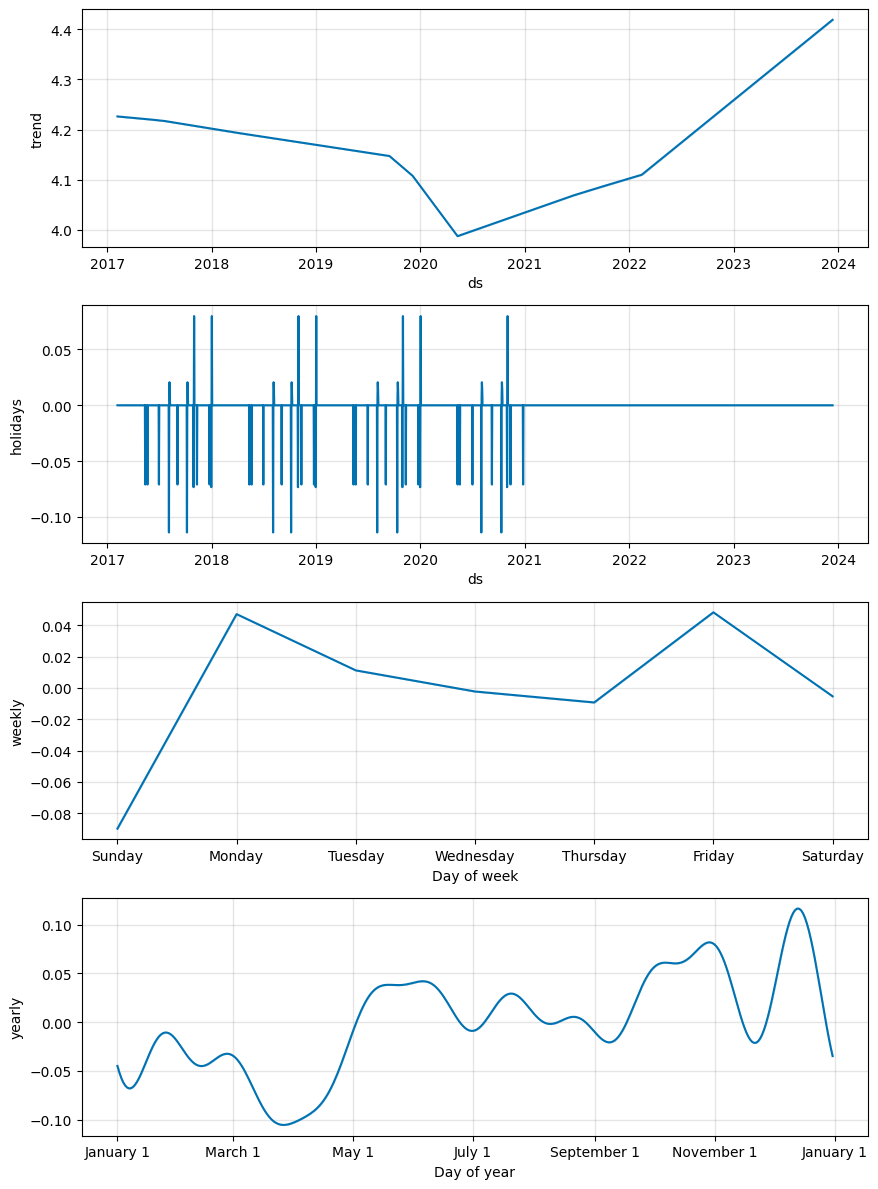

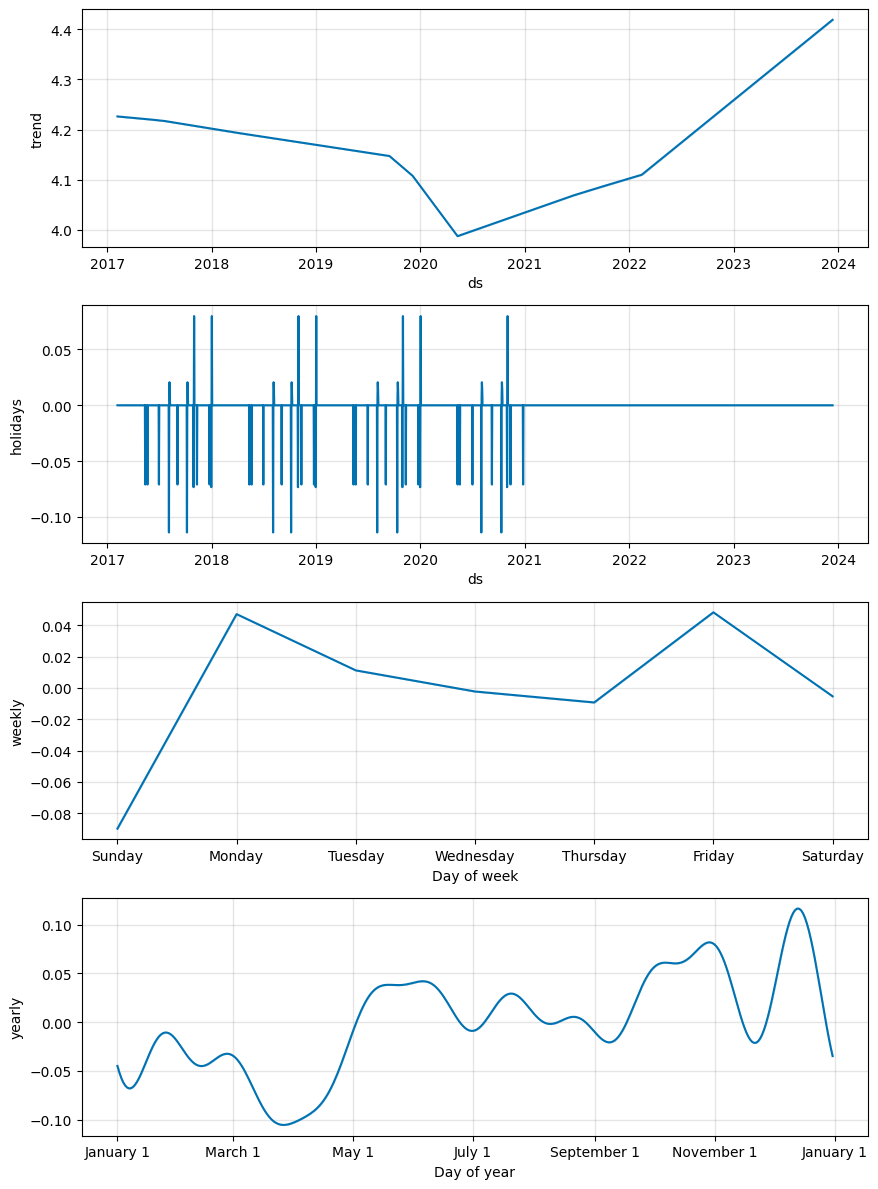

In [ ]:
m3_holidays.plot_components(forecast_m3)

Finding MAPE for holiday model

In [ ]:
# Inverse the log
forecast_m3_exp = np.exp(forecast_m3[['yhat','yhat_lower','yhat_upper']])
forecast_m3_exp.index = forecast_m3['ds']

# Calculate error
error = forecast_m3_exp['yhat'] - y['y']
MAPE_m3 = (error/y['y']).abs().sum()/n *100
round(MAPE_m3,2)

13.21

All three error values together

In [ ]:
print('M1:', round(MAPE_m1,2), '--> Plain','\n')
print('M2:', round(MAPE_m2,2), '--> Without outliers','\n')
print('M3:', round(MAPE_m3,2),'--> Plain with holidays','\n')

M1: 25.31 --> Plain 

M2: 13.25 --> Without outliers 

M3: 13.21 --> Plain with holidays 



In [ ]:
!pip install geopandas descartes folium mapclassify mpld3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 kB 2.3 MB/s eta 0:00:00


In [ ]:
import os
import os.path
import zipfile

Acquiring map data for other possible visuals

In [ ]:
def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

url = 'https://www2.census.gov/geo/tiger/TIGER2018/ROADS/tl_2018_24033_roads.zip'
local_path = './tl_2018_24033_roads.zip'

if not os.path.isfile(local_path):
  print('downloading tl_2018_24033_roads.zip file...')
  download_url(url, local_path)
  with zipfile.ZipFile(local_path, 'r') as zip_ref:
    zip_ref.extractall('./')
  print('tl_2018_24033_roads.zip file downloaded.')
else:
  print('tl_2018_24033_roads.zip file exists.')

downloading tl_2018_24033_roads.zip file...
tl_2018_24033_roads.zip file downloaded.


In [ ]:
import matplotlib.pyplot as plt, mpld3
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

Displaying map

<Axes: >

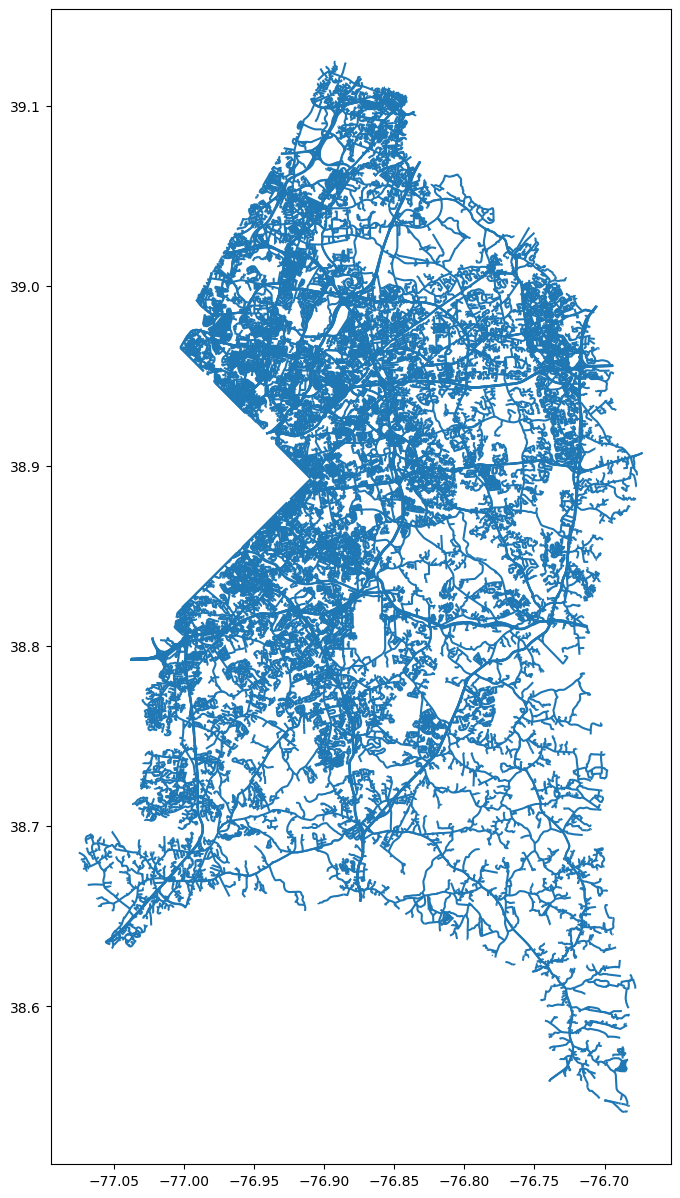

In [ ]:
%matplotlib inline

street_map = gpd.read_file('/content/tl_2018_24033_roads.shp')

fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax=ax)

Creating geodataframe from crime data

In [ ]:
crs = {'init':'epsg:4326'}
geometry = [Point(xy) for xy in zip(historical_df['longitude'], historical_df['latitude'])]

geo_df = gpd.GeoDataFrame(data=historical_df, #specify our data
                          crs=crs, #specify our coordinate reference system
                          geometry=geometry) #specify the geometry list we created
geo_df.head()

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,index,incident_case_id,date,clearance_code_inc_type,pgpd_reporting_area,pgpd_sector,pgpd_beat,street_address,latitude,longitude,street_number,day_of_week,month_year,geometry
0,0.0,PP17020200002452,2017-02-02,ACCIDENT,826,D,D1,96TH AVE / GOOD LUCK RD,38.980819,-76.846938,None,Thursday,2017-02,POINT (-76.84694 38.98082)
1,1.0,PP17020300000263,2017-02-03,ACCIDENT,602,J,J4,INDIAN HEAD HWY SB / WILSON BRIDGE DR,38.787250,-76.998513,None,Friday,2017-02,POINT (-76.99851 38.78725)
2,2.0,PP17020300001861,2017-02-03,THEFT,405,H,H2,1484 ADDISON RD S,38.866974,-76.892214,1400 BLOCK,Friday,2017-02,POINT (-76.89221 38.86697)
3,3.0,PP17020300000798,2017-02-03,THEFT FROM AUTO,219,B,B63,4500 COLLEGE AVE,38.982131,-76.937817,4500 BLOCK,Friday,2017-02,POINT (-76.93782 38.98213)
4,4.0,PP17020300001916,2017-02-03,ACCIDENT,423,H,H7,5510 SILVER HILL RD SB,38.852866,-76.913211,5500 BLOCK,Friday,2017-02,POINT (-76.91321 38.85287)


Plot by latitude and longitude

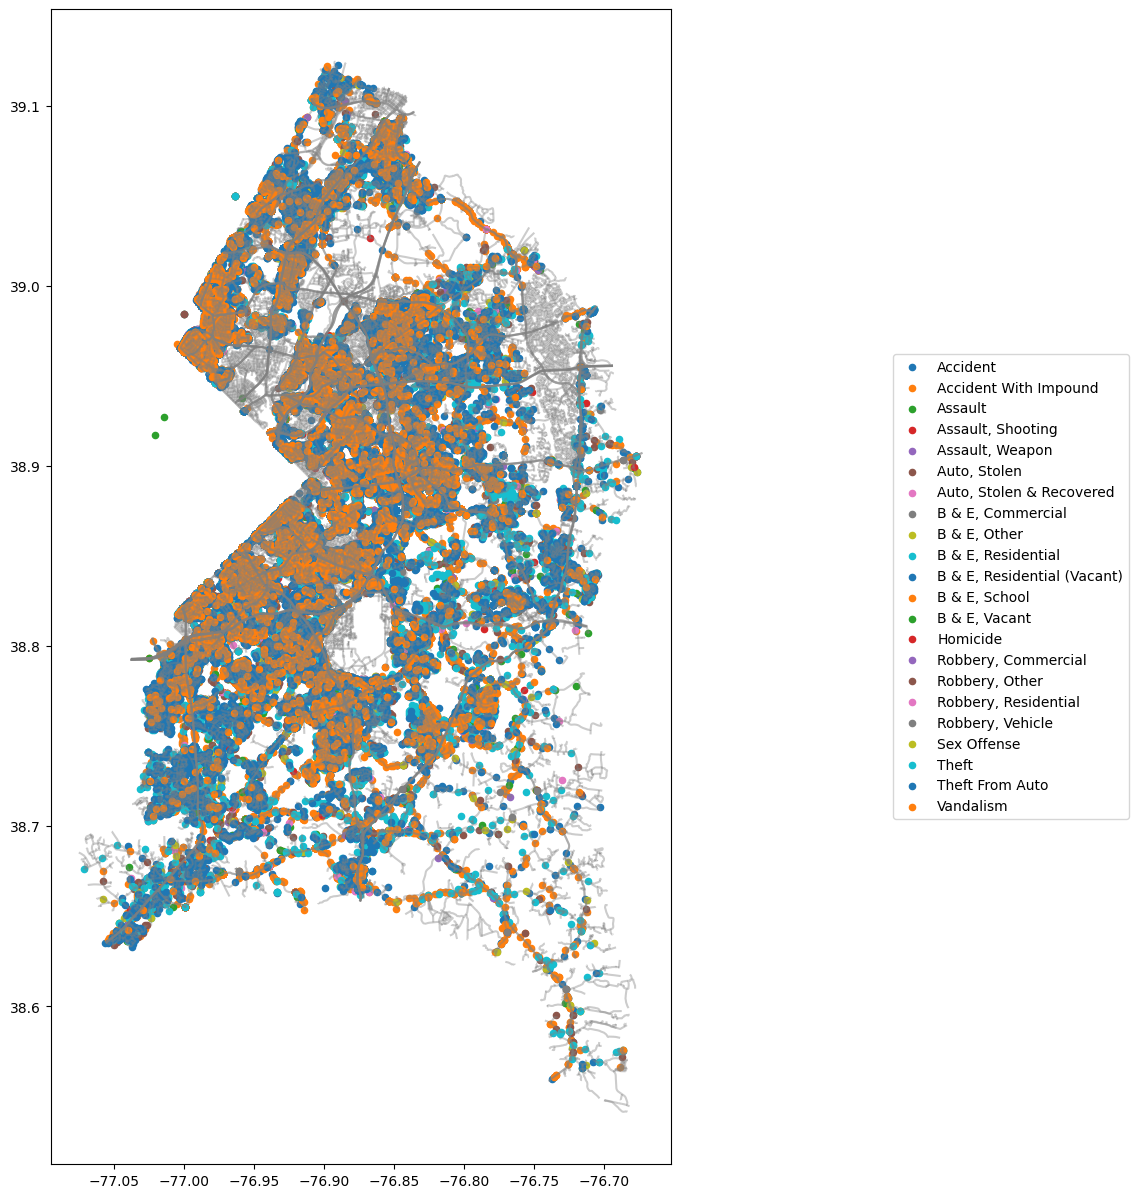

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax=ax, alpha=0.4, color='grey')

incident_grouped = geo_df.groupby('clearance_code_inc_type')

for group_name, df_group in incident_grouped:
  geo_df[geo_df['clearance_code_inc_type'] == group_name].plot(ax=ax,
                                       markersize=20,
                                       marker='o',
                                       label=group_name.title())

ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.5))

In [ ]:
import seaborn as sns

Bar chart for crime types

[Text(0, 0, 'ACCIDENT'),
 Text(1, 0, 'THEFT FROM AUTO'),
 Text(2, 0, 'ACCIDENT WITH IMPOUND'),
 Text(3, 0, 'AUTO, STOLEN'),
 Text(4, 0, 'THEFT'),
 Text(5, 0, 'ASSAULT'),
 Text(6, 0, 'VANDALISM'),
 Text(7, 0, 'B & E, RESIDENTIAL'),
 Text(8, 0, 'ROBBERY, OTHER'),
 Text(9, 0, 'B & E, COMMERCIAL'),
 Text(10, 0, 'AUTO, STOLEN & RECOVERED'),
 Text(11, 0, 'ROBBERY, VEHICLE'),
 Text(12, 0, 'ASSAULT, WEAPON'),
 Text(13, 0, 'SEX OFFENSE'),
 Text(14, 0, 'ROBBERY, COMMERCIAL'),
 Text(15, 0, 'ASSAULT, SHOOTING'),
 Text(16, 0, 'B & E, OTHER'),
 Text(17, 0, 'HOMICIDE'),
 Text(18, 0, 'B & E, VACANT'),
 Text(19, 0, 'ROBBERY, RESIDENTIAL'),
 Text(20, 0, 'B & E, SCHOOL'),
 Text(21, 0, 'B & E, RESIDENTIAL (VACANT)')]

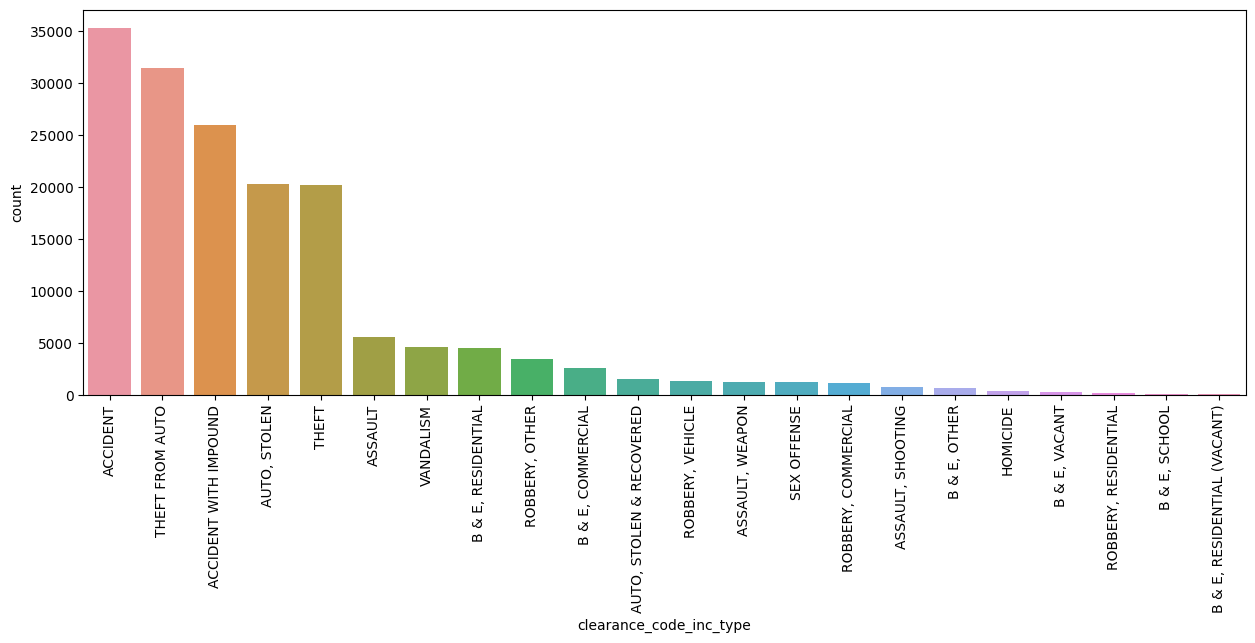

In [ ]:
plt.figure(figsize=(15,5))
ax = sns.countplot(x = historical_df['clearance_code_inc_type'], orient='v', order = historical_df['clearance_code_inc_type'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

Bar chart for day of week

<ipython-input-39-5323d9fd3973>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)


[Text(0.0, 0, '0'),
 Text(5000.0, 0, '5000'),
 Text(10000.0, 0, '10000'),
 Text(15000.0, 0, '15000'),
 Text(20000.0, 0, '20000'),
 Text(25000.0, 0, '25000'),
 Text(30000.0, 0, '30000')]

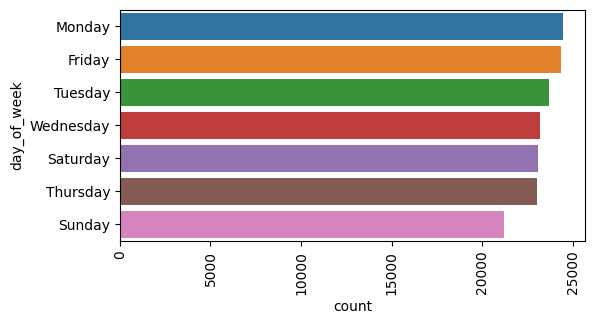

In [ ]:
plt.figure(figsize=(6,3))
ax = sns.countplot(y = historical_df['day_of_week'], orient='h', order = historical_df['day_of_week'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)